In [1]:
## load files, settings, & packages

from scipy.special import erfinv
from scipy.special import loggamma
from scipy.stats import gamma
from scipy.stats import nbinom
from scipy import special
import numpy as np
import sys
import math
sys.path.insert(1,'numerics_snakemake')
from plot_sfs import *
from matplotlib import pyplot as plt
from power_v2 import *
from plot_expseg import *
import seaborn as sns
import inspect
from scipy import stats
import pandas as pd

colors = sns.color_palette("colorblind", 8)
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'Arial'})
plt.rcParams.update({'figure.figsize': '10,8'})
plt.rcParams.update({'lines.linewidth': 6})
plt.rcParams.update({'lines.markersize': 12})

# load data
data = pd.read_csv("numerics_snakemake_20230710/spatial_integrals_dim2.csv")
data_pr = pd.read_csv("numerics_snakemake_20230710/cleaned_data_dim2_errorFalse.csv")
data_pr = data_pr.loc[data_pr['poly_type'] == '1_1']

sigma_vals = data['sigma'].tolist()
kappa_list = data['u2_GQ'].tolist()
res_vals = data_pr['residues']
pole_vals = data_pr['poles']

save_dir = "plots_20230711/"

In [2]:
## functions

def finite_sfs_k(n,k,sigma,s,sigma_vals,pole_vals,res_vals,mu=1e-7,N=100,D=1,d=2):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N,D,d)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,mu,N,D,d)
    logval = k*np.log(n)+alpha*np.log(beta)-(k+alpha)*np.log(n+beta)+loggamma(k+alpha)-loggamma(k+1)-loggamma(alpha)
    return(np.e**logval)

def power(zs, sigma, s, sigma_vals, res_vals, pole_vals, Nval=10000):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N=Nval)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,N=Nval)
    #return(1-gamma.cdf(zs,a=alpha,scale=1/beta))
    return(gamma.sf(zs,a=alpha,scale=1/beta))

def calc_V_G(sigma,kappa_list,sigma_vals,s,beta,L=1e6,mu=1e-8,d=2,D=1,N=10000):
    f = interp1d(sigma_vals,kappa_list,fill_value="extrapolate")
    kappa_val = f(sigma)
    VG_val = (2*L*mu*kappa_val*(beta**2))/(s**2*(np.sqrt(D/s)**d)*N)
    return VG_val

def calc_V_E(sigma,sigma2R,sigma2G,l=1,d=2):
    coef=1-1/((1+2*(sigma/l)**2)**(d/2))
    return(sigma2R+coef*sigma2G)

def get_zs(s,beta,Vp,n,a=1e-8):
    vs = 2*erfinv(1-a)**2
    return(0.5 - (0.5)*math.sqrt(1-(2*vs*(Vp/n))/((beta)**2)))

def power_all(sigma,s,sigma_vals,kappa_list,
              res_vals,pole_vals,
              sigma2R=0.5,sigma2G=0.5,Nval=10000,n=1e6,a=1e-8,L=1e6,mu=1e-8,d=2,D=1,l=1,beta=1.0):
    lc = np.sqrt(D/s)
    Vg=calc_V_G(sigma/lc,kappa_list,sigma_vals,s,beta,N=Nval,L=L,mu=mu,d=d,D=D)#[sigma_vals.index(sigma)]
    Ve=calc_V_E(sigma/lc,sigma2R,sigma2G,l,d)
    Vp=Vg+Ve
    zs=get_zs(s,beta,Vp=Vp,n=n,a=a)
    power_val = power(zs,sigma,s,sigma_vals,res_vals,pole_vals,Nval)
    return(power_val)

def burden_ncp(s,sigma,sigma_vals,pole_vals,res_vals,
               gamma=2,prop_cases=0.5,num_snps=100,num_assoc=100,N=1000,D=1,d=2,mu=1e-8,n=1e6):
    # add later - num_assoc<=num_snps check
    # get rate and shape params
    rate = rate_p(sigma,s,sigma_vals,pole_vals,N=N,D=D,d=d)
    shape = shape_p(sigma,s,sigma_vals,res_vals,mu=mu,N=N,D=D,d=d)
    # calc mean and variance
    r = shape
    p = rate/(rate+n)
    # return ncp
    num_cases = math.floor(prop_cases*n) # round to integer
    num_controls = n-num_cases
    mean = r*(1-p)/p
    var = r*(1-p)/(p**2)#mean/p
    ncp = np.sqrt((2*num_cases*num_controls)/(num_cases+num_controls))*(num_assoc/np.sqrt(num_snps))*(mean/(np.sqrt(var+mean-mean**2)))*(gamma-1)
    return ncp

def power_from_ncp(ncp,alpha,df=1):
    power = 1 - stats.ncx2.cdf(stats.chi2.ppf(1 - alpha, df=1), df=1, nc=ncp)
    return power

def power_all_burden(sigma,s,sigma_vals,
              res_vals,pole_vals,gamma=2,prop_cases=0.1,num_snps=100,num_assoc=100,
             N=10000,n=1e4,mu=1e-8,d=2,D=1,alpha=5e-8,df=1):
    ncp_temp = burden_ncp(s,sigma,sigma_vals,pole_vals,res_vals,gamma=gamma,prop_cases=prop_cases,
                         num_snps=num_snps,num_assoc=num_assoc,N=N,n=n,mu=mu,d=d,D=D)
    power_temp = power_from_ncp(ncp_temp,alpha,df)
    return power_temp

Text(0.5, 0, 'minor allele frequency')

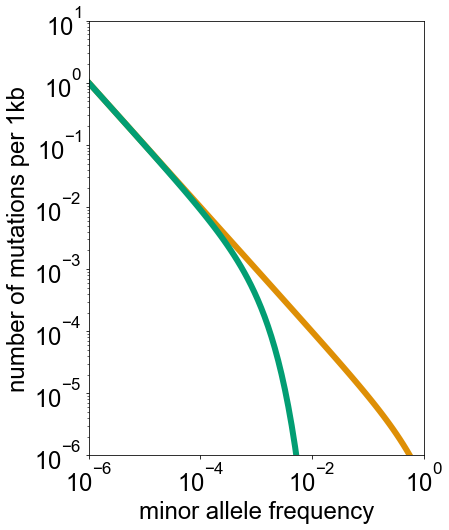

In [3]:
## slide 12 - explanatory figure for SFS

plt.figure(figsize=(6,8))
x = np.logspace(-6,0,100)
k = 0.000001
theta =0.005
k2 = 0.000005
theta2 = 1
theta3=0.001
y = gamma.pdf(x, k,scale=theta)
y2 = gamma.pdf(x,k,scale=theta2)
y3 = gamma.pdf(x,k,scale=theta3)
# plt.plot(x,y,color=colors[0])
plt.plot(x,y2,color=colors[1])
plt.plot(x,y3,color=colors[2])
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-6,1e1)
plt.xlim(1e-6,1e0)
plt.ylabel("number of mutations per 1kb")
plt.xlabel("minor allele frequency")
# plt.savefig(save_dir+"sfs_illustration.pdf")


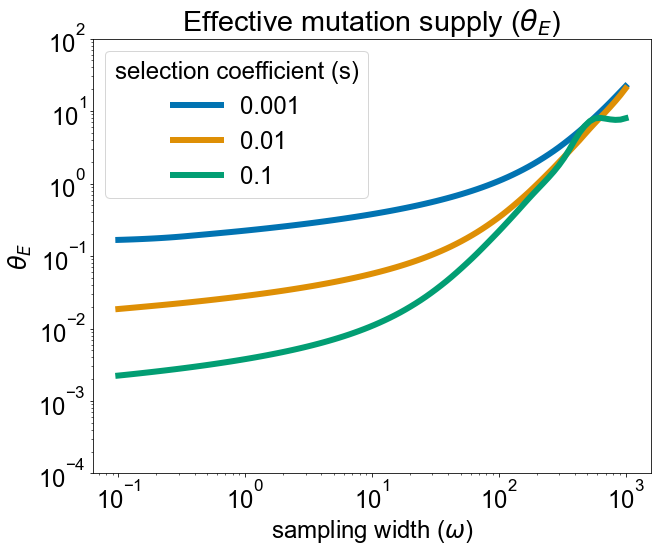

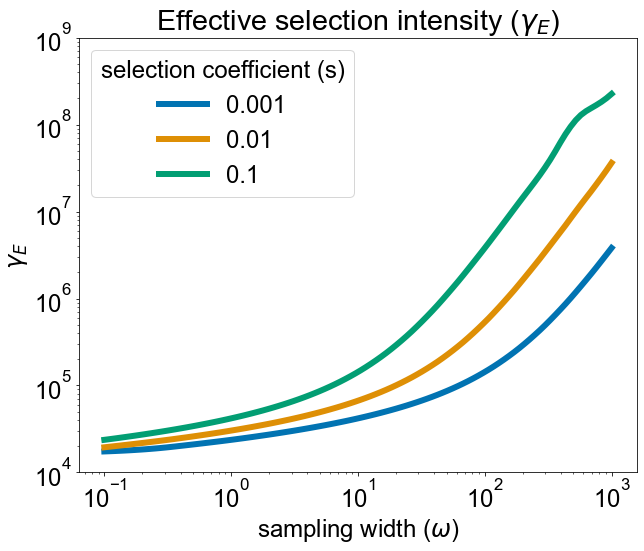

In [4]:
## slide 15 - effective parameter values

fig, ax = plt.subplots()
sigma_range = np.logspace(-1,3,100)
dim = 2
N = 10000
s_vals = [0.001, 0.01, 0.1]
ax.plot(sigma_range,shape_p(s=s_vals[0], sigma=sigma_range, sigma_vals=sigma_vals, res_vals=res_vals,
                    d=dim, N=N), color=colors[0])
ax.plot(sigma_range,shape_p(s=s_vals[1], sigma=sigma_range, sigma_vals=sigma_vals, res_vals=res_vals,
                    d=dim, N=N), color=colors[1])
ax.plot(sigma_range,shape_p(s=s_vals[2], sigma=sigma_range, sigma_vals=sigma_vals, res_vals=res_vals,
                    d=dim, N=N), color=colors[2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"Effective mutation supply ($\theta_E$)")
ax.set_xlabel(r"sampling width ($\omega$)") 
ax.set_ylabel(r"$\theta_E$")
ax.set_ylim(1e-4,1e2)
ax.legend(labels=['0.001', '0.01', '0.1'], title="selection coefficient (s)")
# plt.savefig(save_dir+"eff_mut.pdf")

fig, ax = plt.subplots()
sigma_range = np.logspace(-1,3,100)
dim = 2
N = 10000
s_vals = [0.001, 0.01, 0.1]
ax.plot(sigma_range,rate_p(s=s_vals[0], sigma=sigma_range, sigma_vals=sigma_vals, pole_vals=pole_vals,
                    d=dim, N=N), color=colors[0])
ax.plot(sigma_range,rate_p(s=s_vals[1], sigma=sigma_range, sigma_vals=sigma_vals, pole_vals=pole_vals,
                    d=dim, N=N), color=colors[1])
ax.plot(sigma_range,rate_p(s=s_vals[2], sigma=sigma_range, sigma_vals=sigma_vals, pole_vals=pole_vals,
                    d=dim, N=N), color=colors[2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"Effective selection intensity ($\gamma_E$)")
ax.set_xlabel(r"sampling width ($\omega$)") 
ax.set_ylabel(r"$\gamma_E$")
ax.set_ylim(1e4,1e9)
ax.legend(labels=['0.001', '0.01', '0.1'], title="selection coefficient (s)")
# plt.savefig(save_dir+"eff_sel.pdf")

Text(0, 0.5, 'expected SFS value')

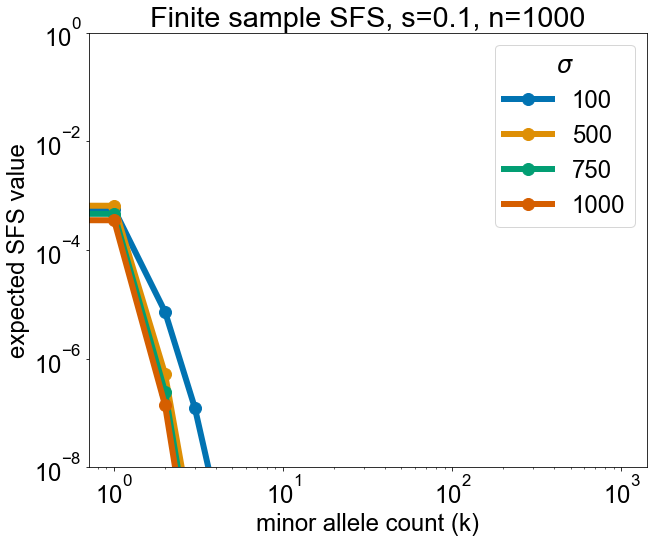

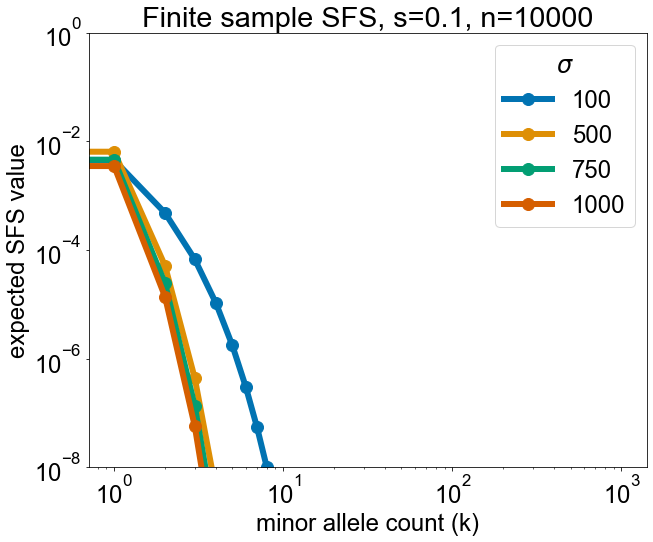

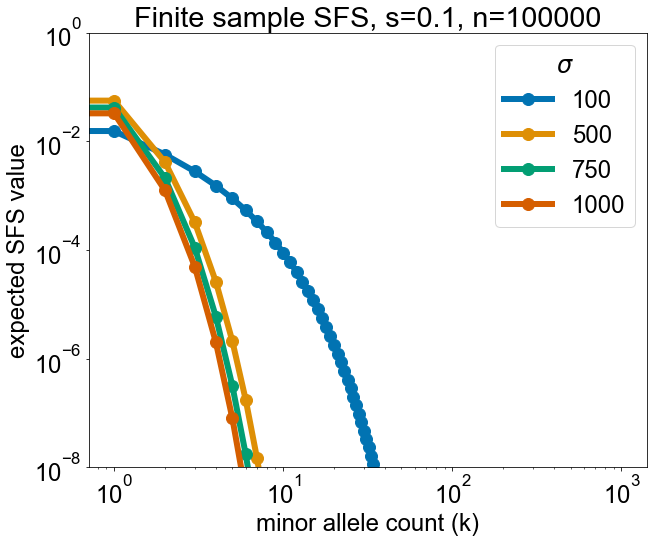

In [5]:
## slide 16 - SFS varying sample size

nval=1000
sval=0.1
kmax=1000
step=1
sg_vals = [100,500,750,1000]
sfs_sg0 = [finite_sfs_k(nval,k,sg_vals[0],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg1 = [finite_sfs_k(nval,k,sg_vals[1],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg2 = [finite_sfs_k(nval,k,sg_vals[2],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg3 = [finite_sfs_k(nval,k,sg_vals[3],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
fig,ax = plt.subplots()
ax.plot(range(0,kmax,step),sfs_sg0,label=str(sg_vals[0]),marker='o',color=colors[0])
ax.plot(range(0,kmax,step),sfs_sg1,label=str(sg_vals[1]),marker='o',color=colors[1])
ax.plot(range(0,kmax,step),sfs_sg2,label=str(sg_vals[2]),marker='o',color=colors[2])
ax.plot(range(0,kmax,step),sfs_sg3,label=str(sg_vals[3]),marker='o',color=colors[3])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8,1e0)
plt.legend(title=r"$\sigma$")
plt.title("Finite sample SFS, s="+str(sval)+", n="+str(nval))
ax.set_xlabel("minor allele count (k)")
ax.set_ylabel("expected SFS value")
# plt.savefig(save_dir+"sfs_finite_s"+str(sval)+"_n"+str(nval)+".pdf")

nval=10000
sval=0.1
kmax=1000
step=1
sg_vals = [100,500,750,1000]
sfs_sg0 = [finite_sfs_k(nval,k,sg_vals[0],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg1 = [finite_sfs_k(nval,k,sg_vals[1],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg2 = [finite_sfs_k(nval,k,sg_vals[2],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg3 = [finite_sfs_k(nval,k,sg_vals[3],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
fig,ax = plt.subplots()
ax.plot(range(0,kmax,step),sfs_sg0,label=str(sg_vals[0]),marker='o',color=colors[0])
ax.plot(range(0,kmax,step),sfs_sg1,label=str(sg_vals[1]),marker='o',color=colors[1])
ax.plot(range(0,kmax,step),sfs_sg2,label=str(sg_vals[2]),marker='o',color=colors[2])
ax.plot(range(0,kmax,step),sfs_sg3,label=str(sg_vals[3]),marker='o',color=colors[3])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8,1e0)
plt.legend(title=r"$\sigma$")
plt.title("Finite sample SFS, s="+str(sval)+", n="+str(nval))
ax.set_xlabel("minor allele count (k)")
ax.set_ylabel("expected SFS value")
# plt.savefig(save_dir+"sfs_finite_s"+str(sval)+"_n"+str(nval)+".pdf")

nval=100000
sval=0.1
kmax=1000
step=1
sg_vals = [100,500,750,1000]
sfs_sg0 = [finite_sfs_k(nval,k,sg_vals[0],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg1 = [finite_sfs_k(nval,k,sg_vals[1],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg2 = [finite_sfs_k(nval,k,sg_vals[2],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
sfs_sg3 = [finite_sfs_k(nval,k,sg_vals[3],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
fig,ax = plt.subplots()
ax.plot(range(0,kmax,step),sfs_sg0,label=str(sg_vals[0]),marker='o',color=colors[0])
ax.plot(range(0,kmax,step),sfs_sg1,label=str(sg_vals[1]),marker='o',color=colors[1])
ax.plot(range(0,kmax,step),sfs_sg2,label=str(sg_vals[2]),marker='o',color=colors[2])
ax.plot(range(0,kmax,step),sfs_sg3,label=str(sg_vals[3]),marker='o',color=colors[3])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8,1e0)
plt.legend(title=r"$\sigma$")
plt.title("Finite sample SFS, s="+str(sval)+", n="+str(nval))
ax.set_xlabel("minor allele count (k)")
ax.set_ylabel("expected SFS value")
# plt.savefig(save_dir+"sfs_finite_s"+str(sval)+"_n"+str(nval)+".pdf")

Text(0.5, 1.05, 'GWAS power (s=0.1, n=500000.0, density=10000, $\\sigma_X^2$=0)')

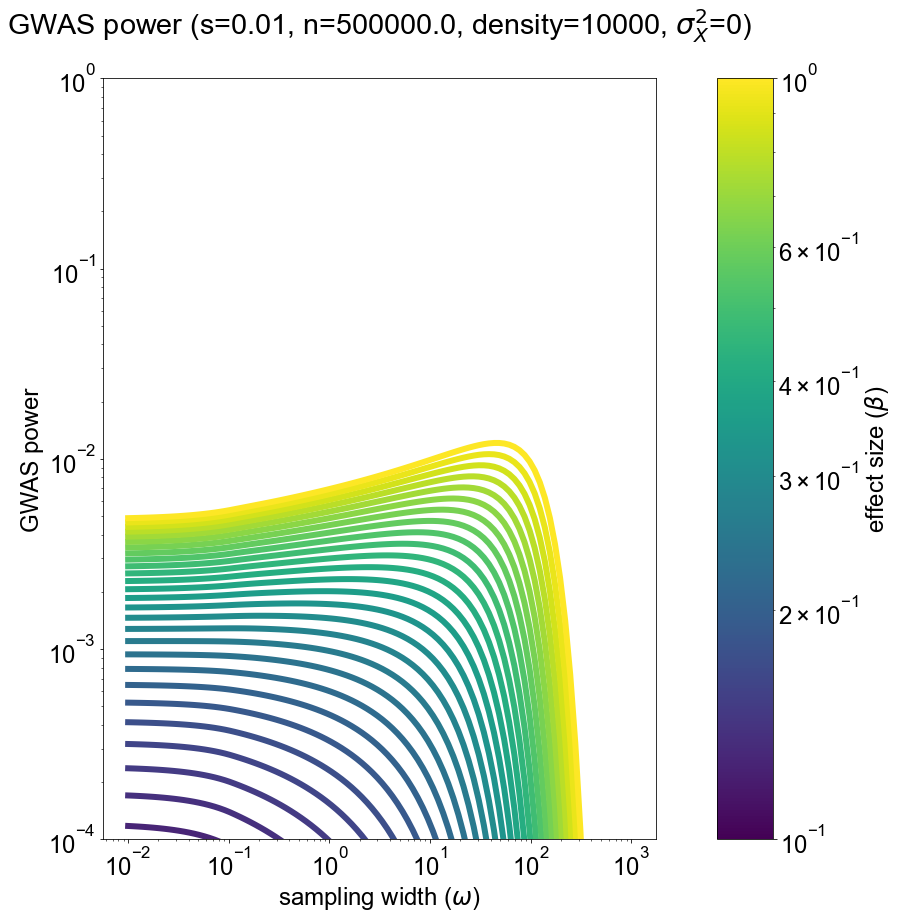

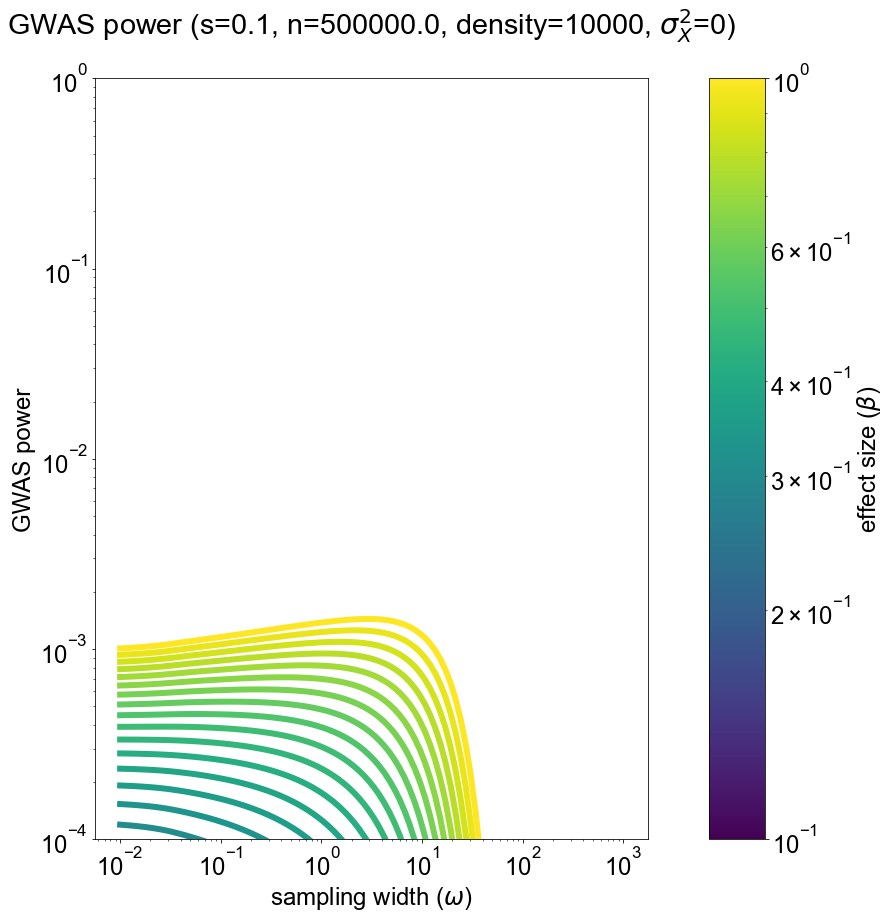

In [6]:
## slide 21 - GWAS power plots

plt.rcParams.update({'figure.figsize': '12,14'})
sval=0.01
ntemp=5e5
dens=10000
s2g=0
b_list = np.logspace(-1,0,30)
# sigma_vals_2=np.logspace(0,3,100)
fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
for i in range(30):
    axs[0].plot(sigma_vals,[power_all(sg, sval, sigma_vals, kappa_list, res_vals, pole_vals,beta=b_list[i],n=ntemp,Nval=dens,sigma2G=s2g)
                for sg in sigma_vals],color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"sampling width ($\omega$)")
axs[0].set_ylabel("GWAS power")
# axs[0].set_xlim(1e-1,1e2)
axs[0].set_ylim(1e-4,1e0)
norm = mpl.colors.LogNorm(vmin=min(b_list), vmax=max(b_list))
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                    norm=norm,
                                    orientation='vertical')
cb1.set_label(r'effect size ($\beta$)')
axs[0].set_title(r"GWAS power (s="+str(sval)+", n="+str(ntemp)+", density="+str(dens)+", $\sigma_X^2$="+str(s2g)+")",y=1.05)
# plt.savefig(save_dir+"gwas_s"+str(sval)+"_n"+str(nval)+"_dens"+str(dens)+"_sig2x"+str(s2g)+".pdf")


sval=0.1
ntemp=5e5
dens=10000
s2g=0
b_list = np.logspace(-1,0,30)
# sigma_vals_2=np.logspace(0,3,100)
fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
for i in range(30):
    axs[0].plot(sigma_vals,[power_all(sg, sval, sigma_vals, kappa_list, res_vals, pole_vals,beta=b_list[i],n=ntemp,Nval=dens,sigma2G=s2g)
                for sg in sigma_vals],color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"sampling width ($\omega$)")
axs[0].set_ylabel("GWAS power")
# axs[0].set_xlim(1e-1,1e2)
axs[0].set_ylim(1e-4,1e0)
norm = mpl.colors.LogNorm(vmin=min(b_list), vmax=max(b_list))
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                    norm=norm,
                                    orientation='vertical')
cb1.set_label(r'effect size ($\beta$)')
axs[0].set_title(r"GWAS power (s="+str(sval)+", n="+str(ntemp)+", density="+str(dens)+", $\sigma_X^2$="+str(s2g)+")",y=1.05)
# plt.savefig(save_dir+"gwas_s"+str(sval)+"_n"+str(nval)+"_dens"+str(dens)+"_sig2x"+str(s2g)+".pdf")


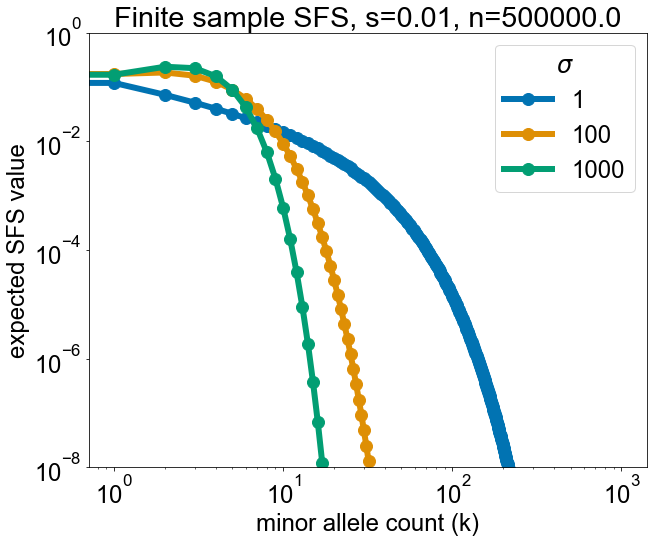

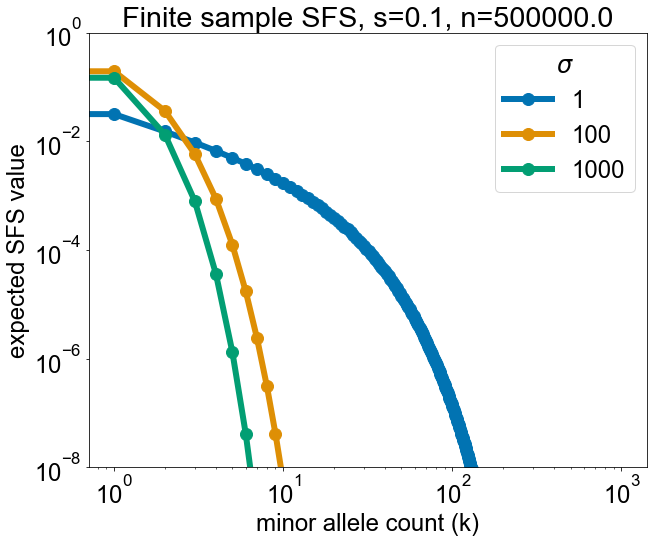

In [7]:
## slide 22 - SFS to match slide 21

plt.rcParams.update({'figure.figsize': '10,8'})
colors = sns.color_palette("colorblind", 8)

nval=5e5
sval=0.01
kmax=1000
dens=10000
step=1
sg_vals = [1,100,1000]
sfs_sg0 = [finite_sfs_k(nval,k,sg_vals[0],sval,sigma_vals,pole_vals,res_vals,N=dens) for k in range(0,kmax,step)]
sfs_sg1 = [finite_sfs_k(nval,k,sg_vals[1],sval,sigma_vals,pole_vals,res_vals,N=dens) for k in range(0,kmax,step)]
sfs_sg2 = [finite_sfs_k(nval,k,sg_vals[2],sval,sigma_vals,pole_vals,res_vals,N=dens) for k in range(0,kmax,step)]
# sfs_sg3 = [finite_sfs_k(nval,k,sg_vals[3],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
fig,ax = plt.subplots()
ax.plot(range(0,kmax,step),sfs_sg0,label=str(sg_vals[0]),marker='o',color=colors[0])
ax.plot(range(0,kmax,step),sfs_sg1,label=str(sg_vals[1]),marker='o',color=colors[1])
ax.plot(range(0,kmax,step),sfs_sg2,label=str(sg_vals[2]),marker='o',color=colors[2])
# ax.plot(range(0,kmax,step),sfs_sg3,label=str(sg_vals[3]),marker='o',color=colors[3])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8,1e0)
plt.legend(title=r"$\sigma$")
plt.title("Finite sample SFS, s="+str(sval)+", n="+str(nval))
ax.set_xlabel("minor allele count (k)")
ax.set_ylabel("expected SFS value")
plt.savefig("plots_20230711/sfs_finite_s"+str(sval)+"_n"+str(nval)+".pdf")

nval=5e5
sval=0.1
kmax=1000
dens=10000
step=1
sg_vals = [1,100,1000]
sfs_sg0 = [finite_sfs_k(nval,k,sg_vals[0],sval,sigma_vals,pole_vals,res_vals,N=dens) for k in range(0,kmax,step)]
sfs_sg1 = [finite_sfs_k(nval,k,sg_vals[1],sval,sigma_vals,pole_vals,res_vals,N=dens) for k in range(0,kmax,step)]
sfs_sg2 = [finite_sfs_k(nval,k,sg_vals[2],sval,sigma_vals,pole_vals,res_vals,N=dens) for k in range(0,kmax,step)]
# sfs_sg3 = [finite_sfs_k(nval,k,sg_vals[3],sval,sigma_vals,pole_vals,res_vals) for k in range(0,kmax,step)]
fig,ax = plt.subplots()
ax.plot(range(0,kmax,step),sfs_sg0,label=str(sg_vals[0]),marker='o',color=colors[0])
ax.plot(range(0,kmax,step),sfs_sg1,label=str(sg_vals[1]),marker='o',color=colors[1])
ax.plot(range(0,kmax,step),sfs_sg2,label=str(sg_vals[2]),marker='o',color=colors[2])
# ax.plot(range(0,kmax,step),sfs_sg3,label=str(sg_vals[3]),marker='o',color=colors[3])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8,1e0)
plt.legend(title=r"$\sigma$")
plt.title("Finite sample SFS, s="+str(sval)+", n="+str(nval))
ax.set_xlabel("minor allele count (k)")
ax.set_ylabel("expected SFS value")
plt.savefig(save_dir+"sfs_finite_s"+str(sval)+"_n"+str(nval)+".pdf")


Text(0.5, 1.05, 'Burden test power (s=0.1, density=10000, num cases=500.0, num snps=100)')

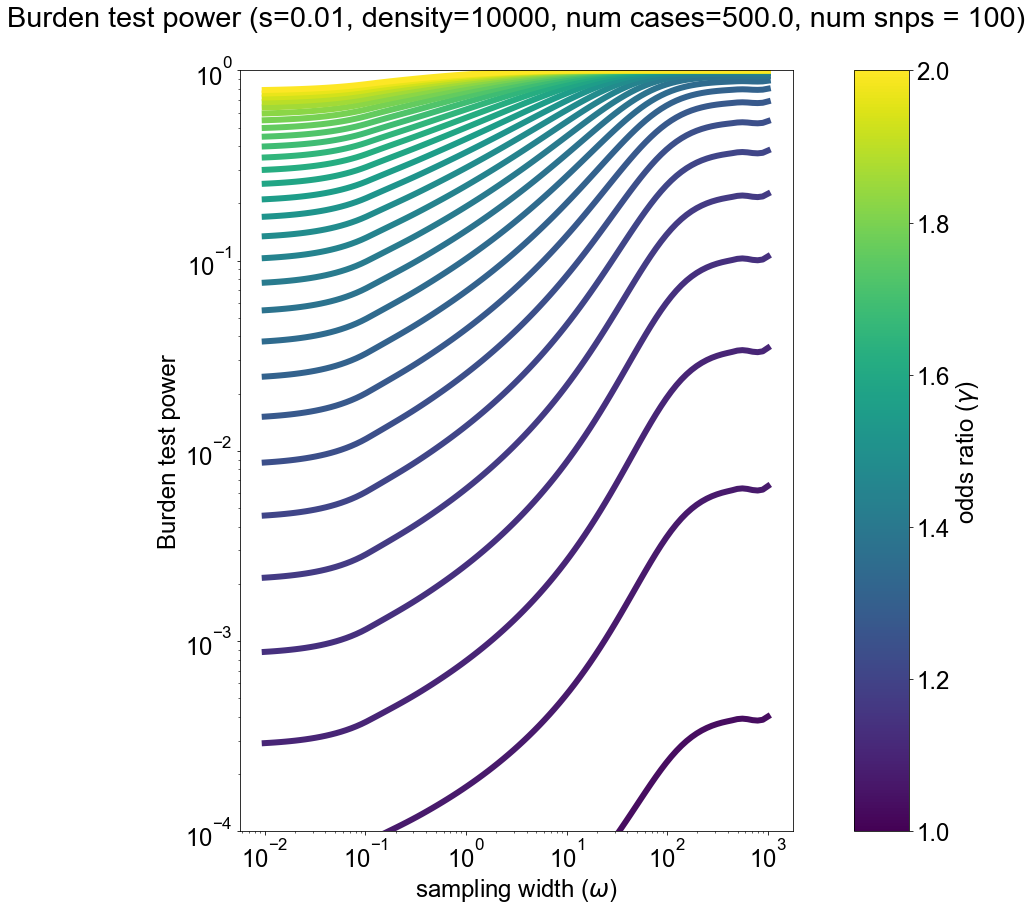

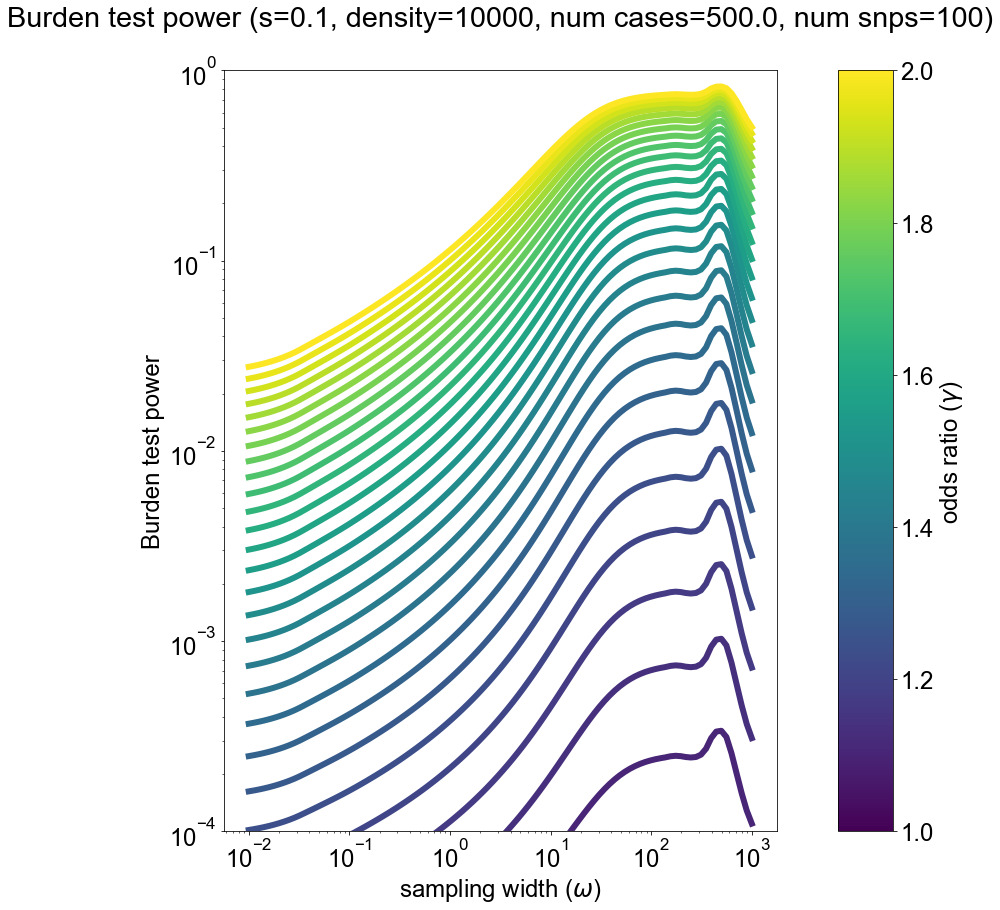

In [8]:
## slide 23 - burden test power

plt.rcParams.update({'figure.figsize': '12,14'})

sval=0.01
ntemp = 5e5
dens=10000
ccratio=1e-3
g_list = np.linspace(1,2,30)
fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
# sigma_vals_2 = np.logspace(0,3,100)
for i in range(30):
    axs[0].plot(sigma_vals,[power_all_burden(sg, sval, sigma_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=g_list[i],n=ntemp,N=dens)
                for sg in sigma_vals],color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"sampling width ($\omega$)")
axs[0].set_ylabel("Burden test power")
# axs[0].set_xlim(1e-1,1e2)
axs[0].set_ylim(1e-4,1e0)
norm = mpl.colors.Normalize(vmin=min(g_list), vmax=max(g_list))
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                    norm=norm,
                                    orientation='vertical')
cb1.set_label(r'odds ratio ($\gamma$)')
axs[0].set_title(r"Burden test power (s="+str(sval)+", density="+str(dens)+", num cases="+str(ccratio*ntemp)+", num snps = 100)",y=1.05)
# plt.savefig(save_dir+"burden_s"+str(sval)+"_n"+str(nval)+"_dens"+str(dens)+"_ccratio"+str(ccratio)+"_k100.pdf")

sval=0.1
ntemp = 5e5
dens=10000
ccratio=1e-3
g_list = np.linspace(1,2,30)
fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
# sigma_vals_2 = np.logspace(0,3,100)
for i in range(30):
    axs[0].plot(sigma_vals,[power_all_burden(sg, sval, sigma_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=g_list[i],n=ntemp,N=dens)
                for sg in sigma_vals],color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"sampling width ($\omega$)")
axs[0].set_ylabel("Burden test power")
# axs[0].set_xlim(1e-1,1e2)
axs[0].set_ylim(1e-4,1e0)
norm = mpl.colors.Normalize(vmin=min(g_list), vmax=max(g_list))
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                    norm=norm,
                                    orientation='vertical')
cb1.set_label(r'odds ratio ($\gamma$)')
axs[0].set_title(r"Burden test power (s="+str(sval)+", density="+str(dens)+", num cases="+str(ccratio*ntemp)+", num snps=100)",y=1.05)
# plt.savefig(save_dir+"burden_s"+str(sval)+"_n"+str(nval)+"_dens"+str(dens)+"_ccratio"+str(ccratio)+"_k100.pdf")


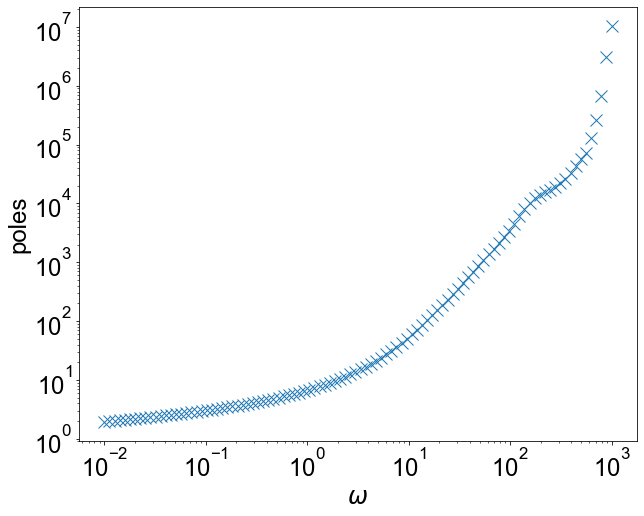

In [19]:
plt.rcParams.update({'figure.figsize': '10,8'})
plt.plot(sigma_vals,pole_vals,marker="x",linestyle='')
plt.xlabel(r"$\omega$")
plt.ylabel("poles")
plt.xscale('log')
plt.yscale('log')

(-100000000.0, 0.0)

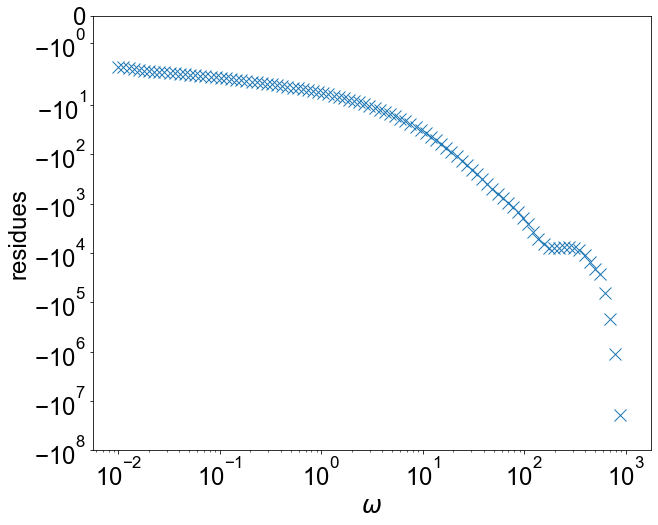

In [20]:
plt.plot(sigma_vals,res_vals,marker="x",linestyle='')
plt.xlabel(r"$\omega$")
plt.ylabel("residues")
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(-1e8,0)